<a href="https://colab.research.google.com/github/SeongwonTak/Data_Practices/blob/master/HRDataProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 퇴사자 예측 Project

구글 colab에서 HR 관련 Data라는 흥미로운 Dataset을 발견하여 분석에 도전해보기로 한다. 마침 분류 문제이자 범주형 데이터가 많아 연습이 필요한 부분이 잘 반영되어 있는 데이터셋이라 도전하기에 좋은 데이터로 판단되었다.

출처> https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists



## 1. 문제와 변수들의 의미

### 문제
주어진 데이터셋을 바탕으로 퇴사가 예측되는 직원을 분류해라.

### 독립변수
- enrollee id : 변수
- City Code : 회사가 있는 도시, City_(숫자) 형식으로 표기
- City development : 도시의 발전 정도.
- Gender : 성별
- Relevent experience : 업무 관련 경력/경험이 있는가?
- enrolled university : 대학에 등록되어있는가?, 혹은 그 유형은?
- major_discipline : 자신의 전공/분야는 무엇인가?
- experience : 최종 경력은 몇년인가?
- company_size : 직원 수는 몇명인가?
- companu_type : 직장 이름/종류
- last_new_job : 이전 직업과 현 직업간의 년수 차이
- training_hours : 교육 이수시간.

### 종속변수(Target)
- 0 : 새 직업/직장을 찾지 않을 것이다.
- 1 : 새 직업/직장을 찾으려고 할 것이다.


## 2. 가설 및 분석모델 선택

### 가설
- 도시의 발전 정도가 이직에 영향을 줄까? 발전정도가 낮을수록 이직결심율이 높다.
- 성별에 따라 이직결심율이 다를 수 있을까? 성별은 영향을 주지 않을 것 같다.
- 현재 대학 교육을 받고 있으면, 이직결심율에 영향을 줄 것이다.
- 업무 관련 경험이 맞지 않다면 이직결심율이 높을 것이다.
- 직원수가 작은 기업일수록 이직결심율이 높을 것이다.
- 교육 이수 시간이 영향을 줄까? 교육을 많이 받았으면 능력이 있어 이직결심율이 높을 것이다.

### 분석모델
- 이직을 한다/안한다 이진 분류의 상황이므로 로지스틱 회귀 모델을 사용할려고 한다.
- 주어진 Train set을 Train Set + Validation Set으로 나눠 Train Set 학습 결과를 Validation Set으로 나눌려고 한다. Validation Set에서 F1-Score을 확인하고자 한다.

## 3. 데이터 탐색 과정

In [2]:
# 패키지를 먼저 import 한다. 추가로 필요한 패키지는 그때그때.
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [54]:
# data_set loading
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HRDataProject/aug_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HRDataProject/aug_test.csv')

In [ ]:
train_data.tail()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0
19157,23834,city_67,0.855,NaN,No relevent experience,no_enrollment,Primary School,NaN,2,NaN,NaN,1,127,0.0


결측치랑 종류별 변수를 좀 정리하려고 한다.

- enrollee_id. id? 아무리봐도 사원번호다. 없애자.
- city : 종류별 번호를 보자.
- city_development_index : 최소가 0, 최대가 1이겠지?
- gender : 당장 NAN이 보인다. 결측치를 제외하고 퇴사율을 비교하여, 의미가 없는 데이터라면, 성별은 없애도 그만.
- relevent_experience : 결측치를 찾자. 대신0 또는 1로 분류하여 있으면 1, 없으면 0으로 표기 대비를 해두자.
- enrolled_university : 같은식으로. 분류.
- major_discipline : 전공별 분류. 
- company_size : NAN이 생각보다 많아보이는데,?
- company_type : 역시 NAN이 너무 많아 보인다...
- last_new_job : 결측치 및 분포 확인
- traiing_hours : 결측치 및 분포 확인

In [ ]:
# 결측치 개수 확인
train_data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
check_cols = ['gender','enrolled_university', 'education_level', 'major_discipline',
              'experience', 'company_size', 'company_type']
for i in check_cols:
  print(train_data.value_counts(i), sep='\n')


gender
Male      13221
Female     1238
Other       191
dtype: int64
enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
dtype: int64
education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
dtype: int64
major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
dtype: int64
experience
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
dtype: int64
company_size
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
dtype: int64
company_type
Pvt Ltd              

In [ ]:
train_data.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


수치형 및 범주형 데이터에 대해서 기본 통계량을 확인해 보았다.

- city_development와 training_hours의 경우는 이미 결측치가 없으므로 분포를 검증하는데 문제가 없다. 분포 확인후 scaling을 실시하기로 한다.
- sex의 경우는 결측치를 채우기 전, male과 female간의 target 평균을 비교하자. 평균 차이가 의미가 있는지 통계검정을 실시, 의미가 없다면 아예 sex에 대해 고려하지 않을 것이다.
- education_level이나 univ.에 대해서도 비슷하게 target 평균 비교하자.
- 전공은? 전공을 다른 데이터랑 연관지어야할지, 독립적으로 고려할지를 결정해야 할 것이다.


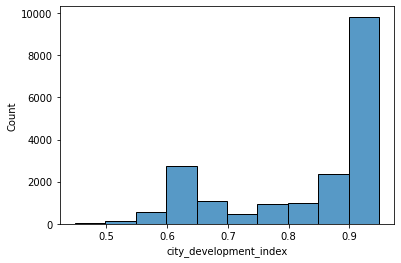

In [ ]:
# city_development의 분포 검증
sns.histplot(data = train_data['city_development_index'], bins=10)
plt.show()

# 역으로 0.9 이상이 몰려있다. 1에서 이 값을 빼서 로그로 하던가
# 아니면 발전률 자체가 중요해서 min-max를 고려하는 것도 방법이다.

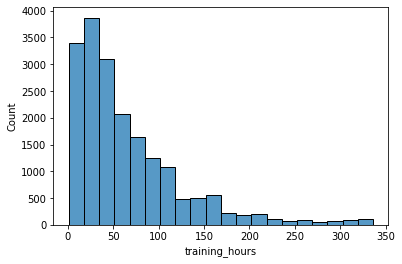

In [ ]:
# training의 분포 검증
sns.histplot(data = train_data['training_hours'], bins=20)
plt.show()

# 결과는 작은 값에 몰려있으므로 이를 로그 분포로 활용을 해야 할 것이다.

In [ ]:
# Sex 특히 Male/Female에 대해 Target 비율에 차이가 의미있는지부터 확인하자.
print(train_data.groupby(by=['gender'], as_index=False).sum())
print(train_data.groupby(by=['gender'], as_index=False).std())
print(train_data.groupby(by=['gender'], as_index=False).count())

   gender  enrollee_id  city_development_index  training_hours  target
0  Female     21606610                1045.788           81258   326.0
1    Male    226232599               11093.115          863300  3012.0
2   Other      3423457                 165.458           12199    50.0
   gender   enrollee_id  city_development_index  training_hours    target
0  Female   9371.955930                0.116264       58.493969  0.440617
1    Male   9867.976684                0.117396       60.053012  0.419441
2   Other  10756.458896                0.096808       59.952513  0.440759
   gender  enrollee_id   city  ...  last_new_job  training_hours  target
0  Female         1238   1238  ...          1232            1238    1238
1    Male        13221  13221  ...         13153           13221   13221
2   Other          191    191  ...           191             191     191

[3 rows x 14 columns]


In [ ]:
import scipy as sp
# 통계 검정의 실시
# 성별에따른 Target의 차이를 확인하는 것이다. 범주형 변수의 분석을 써야 한다.
# 따라서, 카이제곱 독립성 검정으로 실시해야 한다.
male = [9319,3012]
female = [912,326]
sp.stats.chi2_contingency([male, female])

#p-val : 0.14로 유의수준 이상이므로 성별에 따라 이직결심율이 다르다고 할 수 없다
# 성별은 DROP으로 결정해도 무방해보일까? 다른 변수랑 숨겨진 영역이 없을 수는 있다.

(2.103162318724584,
 0.14699484686356698,
 1,
 array([[9297.55037217, 3033.44962783],
        [ 933.44962783,  304.55037217]]))

In [ ]:
# 같은 과정을 education_level로 보자.
print(train_data.groupby(by=['education_level'], as_index=False).sum())
print(train_data.groupby(by=['education_level'], as_index=False).std())
print(train_data.groupby(by=['education_level'], as_index=False).count())

  education_level  enrollee_id  city_development_index  training_hours  target
0        Graduate    197663732                9553.635          762840  3245.0
1     High School     34237753                1681.956          134495   394.0
2         Masters     72387082                3645.564          275924   935.0
3             Phd      6171585                 365.591           27955    58.0
4  Primary School      5123775                 261.929           19597    41.0
  education_level  enrollee_id  ...  training_hours    target
0        Graduate  9739.115384  ...       60.522653  0.448915
1     High School  9529.458255  ...       59.307288  0.396560
2         Masters  9365.671676  ...       57.955434  0.410453
3             Phd  9391.696923  ...       66.743324  0.347507
4  Primary School  9721.685741  ...       64.889434  0.340254

[5 rows x 5 columns]
  education_level  enrollee_id   city  ...  last_new_job  training_hours  target
0        Graduate        11598  11598  ...         

In [ ]:
# enrolled_university
print(train_data.groupby(by=['enrolled_university'], as_index=False).sum())
print(train_data.groupby(by=['enrolled_university'], as_index=False).std())
print(train_data.groupby(by=['enrolled_university'], as_index=False).count())

  enrolled_university  enrollee_id  ...  training_hours  target
0    Full time course     65323820  ...          242448  1431.0
1    Part time course     21118449  ...           80951   302.0
2       no_enrollment    229978469  ...          903107  2921.0

[3 rows x 5 columns]
  enrolled_university  enrollee_id  ...  training_hours    target
0    Full time course  9444.223894  ...       60.069682  0.485670
1    Part time course  9644.413270  ...       65.065184  0.434392
2       no_enrollment  9674.592803  ...       59.617408  0.408321

[3 rows x 5 columns]
  enrolled_university  enrollee_id   city  ...  last_new_job  training_hours  target
0    Full time course         3757   3757  ...          3591            3757    3757
1    Part time course         1198   1198  ...          1167            1198    1198
2       no_enrollment        13817  13817  ...         13624           13817   13817

[3 rows x 14 columns]


In [ ]:
# company_size는?
print(train_data.groupby(by=['company_size'], as_index=False).sum())
print(train_data.groupby(by=['company_size'], as_index=False).std())
print(train_data.groupby(by=['company_size'], as_index=False).count())

  company_size  enrollee_id  city_development_index  training_hours  target
0        10/49     24897353                1197.287           98448   344.0
1      100-500     42219012                2147.117          164504   415.0
2    1000-4999     22199585                1138.266           85817   200.0
3       10000+     34613448                1708.489          130273   385.0
4        50-99     51202726                2556.904          210149   545.0
5      500-999     14404378                 733.945           56376   152.0
6    5000-9999      9642509                 478.023           36338   102.0
7          <10     21428502                1078.606           86069   224.0
  company_size  enrollee_id  city_development_index  training_hours    target
0        10/49  9596.809483                0.131738       62.198513  0.423425
1      100-500  9720.880959                0.119351       59.801147  0.367986
2    1000-4999  9927.922975                0.104686       57.800064  0.357796
3   

In [ ]:
# company_type는?
print(train_data.groupby(by=['company_type'], as_index=False).sum())
print(train_data.groupby(by=['company_type'], as_index=False).std())
print(train_data.groupby(by=['company_type'], as_index=False).count())

          company_type  enrollee_id  ...  training_hours  target
0  Early Stage Startup     10172517  ...           41902   142.0
1       Funded Startup     16231583  ...           67064   140.0
2                  NGO      8828674  ...           35353    97.0
3                Other      1993724  ...            8349    29.0
4        Public Sector     15940585  ...           59258   210.0
5              Pvt Ltd    162308307  ...          640827  1775.0

[6 rows x 5 columns]
          company_type   enrollee_id  ...  training_hours    target
0  Early Stage Startup   9749.702053  ...       63.257722  0.424656
1       Funded Startup  10006.775774  ...       61.016137  0.347015
2                  NGO   9676.580057  ...       64.469137  0.389626
3                Other  10349.437336  ...       59.942194  0.428657
4        Public Sector   9628.330631  ...       56.681681  0.414393
5              Pvt Ltd   9819.175273  ...       60.506644  0.384879

[6 rows x 5 columns]
          company_type  e

In [ ]:
# experience마저도?
print(train_data.groupby(by=['experience'], as_index=False).sum())
print(train_data.groupby(by=['experience'], as_index=False).std())
print(train_data.groupby(by=['experience'], as_index=False).count())

# ! experience가 낮을수록, move할 확률이 높은거 같다는 경향이 보인다.

   experience  enrollee_id  city_development_index  training_hours  target
0           1      9957720                 423.074           35861   233.0
1          10     16341566                 827.552           63710   207.0
2          11     11045782                 561.983           42271   151.0
3          12      7954619                 414.426           34686    92.0
4          13      6671468                 340.929           25330    77.0
5          14      9299253                 502.225           41019   107.0
6          15     10915167                 594.249           44955   114.0
7          16      8960468                 440.444           34991    72.0
8          17      5665127                 293.657           20035    57.0
9          18      4726565                 242.216           18665    43.0
10         19      5086860                 264.715           20809    53.0
11          2     19864312                 876.848           71269   374.0
12         20      240244

In [ ]:
# relevent_experience
print(train_data.groupby(by=['relevent_experience'], as_index=False).sum())
print(train_data.groupby(by=['relevent_experience'], as_index=False).std())
print(train_data.groupby(by=['relevent_experience'], as_index=False).count())

# 잠깐. 경력자가 relevent experience가 없을 수도 있는데..?
# 왜냐? 커리어를 바꾼거니까.
# 새로운 변수를 만들 수 있을 법 하다.
# 해당 변수들을 대상으로 전처리 후 다시 작업할려고 한다.

       relevent_experience  enrollee_id  ...  training_hours  target
0  Has relevent experience    229158061  ...          907516  2961.0
1   No relevent experience     94140051  ...          344783  1816.0

[2 rows x 5 columns]
       relevent_experience  enrollee_id  ...  training_hours    target
0  Has relevent experience  9672.885244  ...       60.081307  0.410622
1   No relevent experience  9437.344103  ...       59.990942  0.473219

[2 rows x 5 columns]
       relevent_experience  enrollee_id  ...  training_hours  target
0  Has relevent experience        13792  ...           13792   13792
1   No relevent experience         5366  ...            5366    5366

[2 rows x 14 columns]


이런, 대체적으로는 변수별로 큰 차이를 보여주는 것은 많지 않아보인다.
다만 다음과 같은 사항들을 발견할 수 있다.

- 총 경력이 길어질수록, 이직결심율이 점점 내려간다. 하지만 정말일까?
- Company type/size를 묶어서 어떤 회사의 규모를 결정할 수 있지 않을까?
  하지만 결측치가 너무 많다. 어떻게 처리를 해줘야할까?
- 위에서 생각한 경력유뮤/경험유무로, 추가 4개 변수를 생성해 주려고 한다.
- 훈련시간(Training)을 구간별로 끊어서 다루려고 한다. 
- city_development 또한 구간별로 끊어서 다루려고 한다.

In [ ]:
# 성별은 아무리 봐도 DROP
train_data = train_data.drop('gender', axis=1)
test_data = test_data.drop('gender', axis=1)

## 4. 데이터 전처리 과정

우선 쉽게 가능한 작업부터 해보자.
다시 한번 결측치를 가져오자.

In [ ]:
train_data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
test_data.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

다음과 같은 순서대로 결측치를 처리할 것이다.

1) 너무 많이 비어있는 줄들을 먼저 없애려고 한다.
아무리 생각해도 company size, company type은 다른 조건으로도 추정이 어려우며 40% 정도 비어있어서 역시 의미가 없어보인다.

In [56]:
train_data = train_data.drop(['company_size', 'company_type'], axis=1)
test_data = test_data.drop(['company_size', 'company_type'], axis=1)

2) 다음, 앞에서 생각한 대로 새로운 데이터 열을 만들 것이다.
- relevent_experience 가 있는지 없는지를 정리하고
- 경력이 있는지 없는지를 정리하자.
- 허나 문제는 경력 줄에 있는 결측치 데이터인데.
  Test set을 보니까, last_new_job에 대한 값 자체도 매우 낮기에
  경력이 매우 작다고 봐도 무방, 경력 없음으로 처리해도 무방해보인다.
- 다음 4가지 범주로 나뉘어 새 변수를 만들어 처리하려고 한다.
  0 : 경력도 없고, 경험도 없다.
  1 : 경력이 없는데 경험은 있다.
  2 : 경력이 있는데 경험은 없다. (진짜?)
  3 : 경력도 있고 경험도 있다. 
- 로지스틱 회귀 문제를 사용해야 하기에 One-hot-encoding을 해야한다.

In [6]:
def relexpchange (x):
    if x == 'Has relevent experience':
      return 1
    else:
      return 0

In [58]:
train_copy = train_data.copy()

In [59]:
train_copy['relevent_experience'] = train_copy['relevent_experience'].apply(relexpchange)

In [ ]:
train_copy.head(7) # 잘 변경되었다.

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,8949,city_103,0.920,1,no_enrollment,Graduate,STEM,>20,1,36,1.0
1,29725,city_40,0.776,0,no_enrollment,Graduate,STEM,15,>4,47,0.0
2,11561,city_21,0.624,0,Full time course,Graduate,STEM,5,never,83,0.0
3,33241,city_115,0.789,0,NaN,Graduate,Business Degree,<1,never,52,1.0
4,666,city_162,0.767,1,no_enrollment,Masters,STEM,>20,4,8,0.0
5,21651,city_176,0.764,1,Part time course,Graduate,STEM,11,1,24,1.0
6,28806,city_160,0.920,1,no_enrollment,High School,NaN,5,1,24,0.0


In [60]:
# 다음은 경험의 결측치를 먼저 채우자.
train_copy['experience'] = train_copy['experience'].fillna(0)

In [10]:
def expchange(x):
  if x == '<1':
    return 0
  elif x == '>20':
    return 21
  else:
    return int(x)

In [61]:
train_copy['experience'] = train_copy['experience'].apply(expchange)

In [ ]:
train_copy.head(7)

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,8949,city_103,0.920,1,no_enrollment,Graduate,STEM,21,1,36,1.0
1,29725,city_40,0.776,0,no_enrollment,Graduate,STEM,15,>4,47,0.0
2,11561,city_21,0.624,0,Full time course,Graduate,STEM,5,never,83,0.0
3,33241,city_115,0.789,0,NaN,Graduate,Business Degree,0,never,52,1.0
4,666,city_162,0.767,1,no_enrollment,Masters,STEM,21,4,8,0.0
5,21651,city_176,0.764,1,Part time course,Graduate,STEM,11,1,24,1.0
6,28806,city_160,0.920,1,no_enrollment,High School,NaN,5,1,24,0.0


In [62]:
train_copy['rel_exp_val'] = 0

In [63]:
for i in range(0, train_copy.shape[0]):
  if train_copy.iloc[i,3] == 0 and train_copy.iloc[i,7] == 0:
    train_copy.iloc[i,11] = 0
  elif train_copy.iloc[i,3] == 1 and train_copy.iloc[i,7] == 0:
    train_copy.iloc[i,11] = 1
  elif train_copy.iloc[i,3] == 0 and train_copy.iloc[i,7] > 0:
    train_copy.iloc[i,11] = 2
  elif train_copy.iloc[i,3] == 1 and train_copy.iloc[i,7] > 0:
    train_copy.iloc[i,11] = 3

In [ ]:
train_copy.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
relevent_experience         int64
enrolled_university        object
education_level            object
major_discipline           object
experience                  int64
last_new_job               object
training_hours              int64
target                    float64
rel_exp_val                 int64
dtype: object

In [ ]:
train_copy.iloc[19157, 7]

2

In [ ]:
train_copy.tail()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target,rel_exp_val
19153,7386,city_173,0.878,0,no_enrollment,Graduate,Humanities,14,1,42,1.0,2
19154,31398,city_103,0.920,1,no_enrollment,Graduate,STEM,14,4,52,1.0,3
19155,24576,city_103,0.920,1,no_enrollment,Graduate,STEM,21,4,44,0.0,3
19156,5756,city_65,0.802,1,no_enrollment,High School,NaN,0,2,97,0.0,1
19157,23834,city_67,0.855,0,no_enrollment,Primary School,NaN,2,1,127,0.0,2


잘 적용된거 같다. 테스트 셋에다가 지금까지 한 거를 적용해주자.

In [64]:
train_data = train_copy
test_copy = test_data.copy()

In [65]:
test_copy['relevent_experience'] = test_copy['relevent_experience'].apply(relexpchange)
test_copy['experience'] = test_copy['experience'].fillna(0)
test_copy['experience'] = test_copy['experience'].apply(expchange)

In [66]:
test_copy['rel_exp_val'] = 0

In [67]:
for i in range(0, test_copy.shape[0]):
  if test_copy.iloc[i,3] == 0 and test_copy.iloc[i,7] == 0:
    test_copy.iloc[i,10] = 0
  elif test_copy.iloc[i,3] == 1 and test_copy.iloc[i,7] == 0:
    test_copy.iloc[i,10] = 1
  elif test_copy.iloc[i,3] == 0 and test_copy.iloc[i,7] > 0:
    test_copy.iloc[i,10] = 2
  elif test_copy.iloc[i,3] == 1 and test_copy.iloc[i,7] > 0:
    test_copy.iloc[i,10] = 3

In [25]:
test_copy.head(10)

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,rel_exp_val
0,32403,city_41,0.827,1,Full time course,Graduate,STEM,9,1,21,3
1,9858,city_103,0.920,1,no_enrollment,Graduate,STEM,5,1,98,3
2,31806,city_21,0.624,0,no_enrollment,High School,NaN,0,never,15,0
3,27385,city_13,0.827,1,no_enrollment,Masters,STEM,11,1,39,3
4,27724,city_103,0.920,1,no_enrollment,Graduate,STEM,21,>4,72,3
5,217,city_23,0.899,0,Part time course,Masters,STEM,10,2,12,2
6,21465,city_21,0.624,1,no_enrollment,Graduate,STEM,0,1,11,1
7,27302,city_160,0.920,1,no_enrollment,Graduate,STEM,21,>4,81,3
8,12994,city_173,0.878,1,no_enrollment,Graduate,STEM,14,4,2,3
9,16287,city_21,0.624,1,Full time course,Graduate,NaN,3,1,4,3


아주 잘 적용된 것으로 보인다. 다시 남은 결측치들을 확인해보자.

In [68]:
test_data = test_copy

In [24]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                   0
last_new_job               423
training_hours               0
target                       0
rel_exp_val                  0
dtype: int64
enrollee_id                 0
city                        0
city_development_index      0
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  0
last_new_job               40
training_hours              0
rel_exp_val                 0
dtype: int64


다음은 last_new_job에 대해 처리를 하자.
train_data를 직접 확인해 본 결과 이것의 경우는 시각적으로는 어떤 경향성을 주는거 같지는 않다.

또한 experience가 높다고 last new job이 높거나, training hours와도 비례관계를 주지 않는다.

또한 특정 년수 초과일 경우 뭉뚱그려 4년 이상 이렇게만 나온다.

이때, 생각해보면 last_new_job의 변수, 그러니까 지난 직장에 몇년 있는거랑 이번 직장이 몇년인지는 퇴사율에 크게 영향을 줄 리가 상식적으로는 없을 것이다.

다른 변수와도 큰 경향성이 없고, 경력자가 20년 이상인 경우가 많은데 4년 이상 식으로 뭉뜽그려트린걸 보면, 데이터가 크게 의미없어보인다. 날려버렷!

In [69]:
train_data = train_data.drop('last_new_job', axis=1)
test_data = test_data.drop('last_new_job', axis=1)

마지막으로 학교/전공 데이터를 채우기 전에 데이터 탐색 과정을 다시 거치고 전처리를 마저 진행할려고 한다..

## 5. 데이터 2차 탐색 및 전처리(후속)

앞에서 만든 train_data 변수 중 하나인 'rel_exp_val'에 따라 실제로 target의 비율에 차이가 있는지 보고 싶다.

In [27]:
# company_type는?
print(train_data.groupby(by=['rel_exp_val'], as_index=False).sum())
print(train_data.groupby(by=['rel_exp_val'], as_index=False).std())
print(train_data.groupby(by=['rel_exp_val'], as_index=False).count())

   rel_exp_val  enrollee_id  ...  training_hours  target
0            0      6690324  ...           24042   162.0
1            1      3617711  ...           12649    98.0
2            2     87449727  ...          320741  1654.0
3            3    225540350  ...          894867  2863.0

[4 rows x 7 columns]
   rel_exp_val  enrollee_id  ...  training_hours    target
0            0  8396.870487  ...       59.401449  0.495361
1            1  8756.245507  ...       58.308678  0.500371
2            2  9512.472532  ...       60.040952  0.470858
3            3  9686.053820  ...       60.106910  0.407865

[4 rows x 7 columns]
   rel_exp_val  enrollee_id   city  ...  experience  training_hours  target
0            0          379    379  ...         379             379     379
1            1          208    208  ...         208             208     208
2            2         4987   4987  ...        4987            4987    4987
3            3        13584  13584  ...       13584           13584   13

실제로 확인해 본 결과 유의미한 차이를 (값만으로도) 느낄 수 있는 부분은
경력도 없고, 경험도 없는 사람이 이직을 생각할 확률이 경험과 경력이 없는 사람이 이직을 생각할 확률보다는 높다는 것이다.

또한, 유의미하게 Test Set에서는 1의 이직결심율이 높았는데, 이는 상식적으로 생각해봐도. 경험은 있지만, 실제로 일을 들어오니, 아 난 이건 아닌거 같아! 이렇게 생각하고 있는 사람들의 비율이라는 것을 추측해 볼 수 있다.

이를 고려해보면, 전공과 상관없이, 관련된 경험/경력의 요소가 크다는 것을 알 수 있다. 따라서 전공이나 학력에 대해서도 크게 고려하지 않아도 될 것 같다.

In [70]:
train_data = train_data.drop(['enrolled_university', 'education_level', 'major_discipline'], axis=1)
test_data = test_data.drop(['enrolled_university', 'education_level', 'major_discipline'], axis=1)

In [21]:
train_data.head()

,enrollee_id,city,city_development_index,relevent_experience,experience,training_hours,target,rel_exp_val
0,8949,city_103,0.920,1,21,36,1.0,3
1,29725,city_40,0.776,0,15,47,0.0,2
2,11561,city_21,0.624,0,5,83,0.0,2
3,33241,city_115,0.789,0,0,52,1.0,0
4,666,city_162,0.767,1,21,8,0.0,3


이제, city_development_index와 training_hours에 대한 scaling 및 분포정리를 할 것이다.
먼저 city의 경우는 0~1 사이의 값을 그래도 지녔기에, 그대로 사용할 것이다.

training_hours의 경우는 log변환을 실시하자.

In [71]:
train_data['training_hours'] = train_data['training_hours'].apply(lambda x: np.log(x+1e-04))

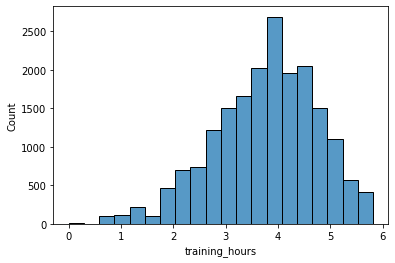

In [25]:
sns.histplot(data = train_data['training_hours'], bins=20)
plt.show()

잘 적용되었다. 이제 이 값의 평균과 분산을 구해, 표준화를 실시할 것이다.
그리고 이 평균과 분산 데이터를 바탕으로, test set에도 변환을 시킬 것이다.

In [26]:
train_data.describe()
# 평균 : 3.76203,  분산 : 0.986975

,enrollee_id,city_development_index,relevent_experience,experience,training_hours,target,rel_exp_val
count,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,0.719908,10.065873,3.762030,0.249348,2.658628
std,9616.292592,0.123362,0.449056,6.790963,0.986975,0.432647,0.604374
min,1.000000,0.448000,0.000000,0.000000,0.000100,0.000000,0.000000
25%,8554.250000,0.740000,0.000000,4.000000,3.135499,0.000000,2.000000
50%,16982.500000,0.903000,1.000000,9.000000,3.850150,0.000000,3.000000
75%,25169.750000,0.920000,1.000000,16.000000,4.477338,0.000000,3.000000
max,33380.000000,0.949000,1.000000,21.000000,5.817111,1.000000,3.000000


In [28]:
def training_hour_scaler(x):
  return (x-3.76203)/0.986975

In [72]:
train_data['training_hours'] = train_data['training_hours'].apply(training_hour_scaler)

In [73]:
test_data['training_hours'] = test_data['training_hours'].apply(lambda x: np.log(x+1e-04))
test_data['training_hours'] = test_data['training_hours'].apply(training_hour_scaler)

In [ ]:
test_data.describe()

마지막으로 rel_exp_val 에 대해서 get_dummies를 적용하자.


In [74]:
train_df = pd.get_dummies(train_data['rel_exp_val'], prefix='rel_exp_val')
train_data = pd.concat([train_data, train_df], axis=1)

In [75]:
train_data.head(5)

,enrollee_id,city,city_development_index,relevent_experience,experience,training_hours,target,rel_exp_val,rel_exp_val_0,rel_exp_val_1,rel_exp_val_2,rel_exp_val_3
0,8949,city_103,0.920,1,21,-0.180864,1.0,3,0,0,0,1
1,29725,city_40,0.776,0,15,0.089283,0.0,2,0,0,1,0
2,11561,city_21,0.624,0,5,0.665480,0.0,2,0,0,1,0
3,33241,city_115,0.789,0,0,0.191713,1.0,0,1,0,0,0
4,666,city_162,0.767,1,21,-1.704781,0.0,3,0,0,0,1


In [76]:
test_df = pd.get_dummies(test_data['rel_exp_val'], prefix='rel_exp_val')
test_data = pd.concat([test_data, test_df], axis=1)

##6. 모델 적용 및 평가 과정

자, 준비는 다 되었다. 이제 마지막으로 해볼 사항을 정리하자.
- train set을 나눠야 한다. train set : validation set을 나눌 것이다. 
- 로지스틱 회귀분석 모델을 적용해보자.
- 회고 및 Kaggle에 평가 데이터를 올린 후 정확도를 높이기 좋은 방법들에 대해 고민해보자.

In [77]:
from sklearn.model_selection import train_test_split

train_data_x = train_data[['city_development_index', 'training_hours','rel_exp_val_0', 'rel_exp_val_1', 'rel_exp_val_2', 'rel_exp_val_3']]
train_data_y = train_data['target']

train_x, valid_x, train_y, valid_y = train_test_split(train_data_x, train_data_y)

잘 분리되었는지를 확인해 보자.

In [78]:
print(train_x.shape, valid_x.shape)

(14368, 6) (4790, 6)


이제, 마지막이다. 분석할 feature를 선정하여 해당 feature를 바탕으로 로지스틱 회귀분석을 실시하기만 하면 된다. scikit-learn에 이미 있으니까.

In [79]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=10, max_iter=10000)
model.fit(train_x, train_y)

print(model.score(train_x, train_y))
print(model.score(valid_x, valid_y))

0.764337416481069
0.7659707724425887


약 76% 정도의 결과율을 보인다.
아쉽기는 한데, 사람 데이터를 다룬 상황에서 생각보다는 괜찮은 결과를 보여준 것으로 보인다. 최종 결과를 확인해보러 가자.

##7. 최종 결과 확인 및 회고

test_set에 적용을 할 차례이다.

In [80]:
X = test_data[['city_development_index', 'training_hours','rel_exp_val_0', 'rel_exp_val_1', 'rel_exp_val_2', 'rel_exp_val_3']]
result = model.predict(X)

In [81]:
test_data['target'] = result

In [82]:
test_data.tail(15)

,enrollee_id,city,city_development_index,relevent_experience,experience,training_hours,rel_exp_val,rel_exp_val_0,rel_exp_val_1,rel_exp_val_2,rel_exp_val_3,target
2114,6294,city_73,0.754,1,21,-0.332369,3,0,0,0,1,0.0
2115,13833,city_21,0.624,1,10,-1.704781,3,0,0,0,1,0.0
2116,31643,city_75,0.939,1,21,0.302353,3,0,0,0,1,0.0
2117,21500,city_44,0.725,0,7,1.330474,2,0,0,1,0,0.0
2118,33225,city_138,0.836,1,14,-0.024679,3,0,0,0,1,0.0
2119,8905,city_70,0.698,0,8,0.248542,2,0,0,1,0,0.0
2120,9772,city_114,0.926,0,5,-0.300201,2,0,0,1,0,0.0
2121,27163,city_173,0.878,0,16,0.302353,2,0,0,1,0,0.0
2122,24507,city_90,0.698,0,20,1.143210,2,0,0,1,0,0.0
2123,21339,city_21,0.624,0,3,0.266799,2,0,0,1,0,1.0


In [85]:
test_data.to_csv('result.csv')

In [86]:
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

( Kaggle에 별도로 노트북을 또 만들어야하나보다. 사용법을 익혀 결과를 업로드 할 예정이다)

점수를 유의미하기 올리기 위해서 다음 방법들이 사용 가능할 것 같다.
- 경력이나 훈련시간에 대해 유의미한 값을 주지 못했다. 이것에 대해서 XGBoost 나 RandomForest를 통해 결과를 향상시킬 수 있을지도 모르겠다.
- 그냥 버려버린 학교나 회사 종류의 데이터에서 다른 유의미한 변수를 새로 뽑아낼 수 있을지도 모르겠다.

(Tree 모델과의 비교는 업로드 예정)